In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import dice_ml
from dice_ml.utils import helpers

SEMINAR_TOPIC_NUMBER = 4
TOPIC_1_DECISION_TREE = True

#https://github.com/interpretml/DiCE/blob/main/docs/source/notebooks/DiCE_model_agnostic_CFs.ipynb

/home/jbn9062/.local/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


The analysis of DiCE explainability method was performed on the Breast Cancer Dataset introduced on 1993 by [Street et al](https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf?sequence=1). The paper has defined 10 nuclear features that are characteristic to individual cells. Our goal is to find how these features varies between benign and melignant tumor cells. Understanding the impact of these features can help us to understand why our model classified a particular cell as benign or malignant.

In [2]:
data = datasets.load_breast_cancer(as_frame=True)
dataset = data['frame'].iloc[:, :10]
dataset["target"] = data['frame']['target']
dataset.columns = list(map(lambda x: x.split(" ")[-1], dataset.columns))

The table above shows 10 features and the last column 'target' holds the binary value (0 or 1), if the cell is malignant the target is 1 otherwise 0.

In [3]:
X = dataset.iloc[:, :10]
y = dataset['target']

# create models
match SEMINAR_TOPIC_NUMBER:
    case 1:
        model = DecisionTreeClassifier(criterion="gini") if TOPIC_1_DECISION_TREE else RandomForestClassifier(criterion="gini")
    case 2:
        model = SVC(kernel="linear")
    case 3:
        model = RidgeClassifier(alpha=0.00001, fit_intercept=False)
    case 4:
        model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50), random_state=1)

# prepare the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

Accuracy:  0.972027972027972


## Explainability
For this work, MLP classifier is used to create a neural network model. Dataset is split into test (Y) and train data (X). A pipeline is created on the MLP model and the StandardScalar function is used to standardize the features to have a mean of 0 and a standard deviation of 1. The classifier is trained on the training data and the score is calculated to evaluate the the performance of the model.

In [4]:
if hasattr(pipeline, "coef_"):
    # Visualize the model coefficients as an example
    plt.bar(range(len(dataset.columns) - 1), pipeline.coef_[0])
    plt.xticks(range(len(dataset.columns) - 1), dataset.columns[:-1], rotation=90)
    plt.show()
else:
    print("Model has no coefficients to be visualized.")

Model has no coefficients to be visualized.


In [5]:
d = dice_ml.Data(dataframe=dataset, continuous_features=['radius',	'texture', 'perimeter',	'area',	'smoothness',	'compactness',	'concavity',	'points',	'symmetry',	'dimension'], outcome_name='target')
backend = 'sklearn'
m = dice_ml.Model(model=pipeline, backend=backend)

d is the DiCE data object. continuous_features holds all the features with continuous values.
DiCE model object (m) is created from the existing machine learning model (pipeline). This allows the DiCE to interact with the pipeline model and generate the counterfactuals.

In [6]:
# initiate DiCE
exp_dice = dice_ml.Dice(d, m, method="random")
query = dataset.drop(columns="target")
exp1 = exp_dice.generate_counterfactuals(query[0:10], total_CFs=5, desired_class="opposite")

exp1.visualize_as_dataframe(show_only_changes=True)


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]

Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,17.99,10.38,122.800003,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,17.99,10.38,122.8,-,0.1184,0.2776,0.3001,0.1471,0.1404,0.07871,1.0
1,17.99,10.38,122.8,-,0.0865,0.2776,0.3001,0.1471,0.2419,0.07871,1.0
2,17.99,10.38,122.8,-,0.1184,0.2776,0.2,0.1471,0.1309,0.07871,1.0
3,17.99,10.38,122.8,-,0.1184,0.2776,0.3001,0.1,0.2419,0.05573,1.0
4,17.99,10.38,166.41,-,0.1184,0.2776,0.3001,0.0,0.2419,0.07871,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.57,17.77,132.899994,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.57,17.77,132.9,-,0.08474,0.2449,0.0869,0.07017,0.1812,0.06084,1.0
1,20.57,17.77,132.9,-,0.08474,0.3436,0.1,0.07017,0.1812,0.05667,1.0
2,20.57,17.77,132.9,-,0.08474,0.3334,0.0869,0.07017,0.1812,0.05667,1.0
3,20.57,17.77,132.9,-,0.08474,0.3247,0.0869,0.07017,0.1812,0.05667,1.0
4,20.57,17.77,132.9,-,0.08474,0.2778,0.0869,0.1,0.1812,0.05667,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,19.690001,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,19.69,-,-,-,0.1588,0.1599,0.1,0.1279,0.2069,0.05999,1.0
1,19.69,-,-,-,0.1096,0.3233,0.1974,0.1279,0.2069,0.05222,1.0
2,19.69,-,-,-,0.0605,0.1599,0.1974,0.1279,0.2069,0.0866,1.0
3,19.69,-,-,-,0.1516,0.1599,0.1974,0.0,0.2069,0.05999,1.0
4,19.69,-,-,-,0.1566,0.1599,0.0,0.1279,0.2069,0.05999,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,11.42,20.379999,77.580002,386.100006,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,21.53,20.38,77.58,386.1,0.1019,0.2839,0.2414,0.1052,0.2597,0.09744,1.0
1,11.42,20.38,77.58,386.1,0.0693,0.2839,0.3,0.1052,0.2597,0.09744,1.0
2,11.42,20.38,77.58,386.1,0.083,0.2839,0.2414,0.1052,0.2597,0.09744,1.0
3,11.42,20.38,64.78,386.1,0.084,0.2839,0.2414,0.1052,0.2597,0.09744,1.0
4,11.42,20.38,77.58,386.1,0.0968,0.2839,0.4,0.1052,0.2597,0.09744,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.290001,14.34,135.100006,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.29,14.34,135.1,-,0.1003,0.3343,0.198,0.1043,0.1809,0.05883,1.0
1,20.29,14.34,135.1,-,0.1003,0.297,0.198,0.1043,0.1809,0.05883,1.0
2,20.29,14.34,135.1,-,0.1003,0.3041,0.1,0.1043,0.1809,0.05883,1.0
3,20.29,14.34,135.1,-,0.1631,0.1328,0.1,0.1043,0.1809,0.05883,1.0
4,20.29,14.34,135.1,-,0.1003,0.3288,0.198,0.1043,0.1809,0.05883,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,12.45,15.7,82.57,477.100006,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,10.19,15.7,82.57,477.1,0.0819,0.17,0.1578,0.08089,0.2087,0.07613,1.0
1,19.1,15.7,82.57,477.1,0.1278,0.17,0.0,0.08089,0.2087,0.07613,1.0
2,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.0,0.1676,0.07613,1.0
3,12.45,15.7,82.57,2295.5,0.0552,0.17,0.1578,0.08089,0.2087,0.07613,1.0
4,12.45,10.92,82.57,477.1,0.1278,0.2472,0.1578,0.08089,0.2087,0.07613,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,18.25,19.98,119.599998,1040.0,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,-,19.98,119.6,-,0.1384,0.109,0.1127,0.074,0.1794,0.05742,1.0
1,-,19.98,119.6,-,0.09463,0.2999,0.1127,0.074,0.1794,0.05255,1.0
2,-,19.98,119.6,-,0.09463,0.2817,0.4,0.074,0.1794,0.05742,1.0
3,-,19.98,119.6,-,0.09463,0.3381,0.1127,0.074,0.1794,0.05742,1.0
4,-,19.98,119.6,-,0.0581,0.109,0.1127,0.074,0.1284,0.05742,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,13.71,20.83,90.199997,577.900024,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,16.08,20.83,90.2,577.9,0.1434,0.1645,0.09366,0.05985,0.2196,0.07451,1.0
1,13.71,20.83,63.45,577.9,0.1189,0.1645,0.09366,0.0,0.2196,0.07451,1.0
2,13.71,20.83,112.59,577.9,0.1189,0.1645,0.09366,0.0,0.2196,0.07451,1.0
3,13.71,14.11,107.9,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,1.0
4,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.1211,0.07451,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,13.0,21.82,87.5,519.799988,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,-,21.82,-,519.8,0.0885,0.1932,0.1859,0.09353,0.235,0.07389,1.0
1,-,21.82,-,798.0,0.1273,0.1932,0.1859,0.09353,0.235,0.05363,1.0
2,-,21.82,102.37,519.8,0.1273,0.1932,0.1859,0.09353,0.124,0.07389,1.0
3,-,21.82,-,519.8,0.0603,0.1932,0.1859,0.09353,0.235,0.07389,1.0
4,21.32,21.82,-,519.8,0.0697,0.1932,0.1859,0.09353,0.235,0.07389,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,12.46,24.040001,83.970001,475.899994,0.1186,0.2396,0.2273,0.08543,0.203,0.08243,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,12.46,24.04,83.97,475.9,0.0872,0.2396,0.2273,0.08543,0.203,0.08243,1.0
1,12.46,24.04,83.97,475.9,0.0851,0.2396,0.2,0.08543,0.203,0.08243,1.0
2,12.46,24.04,83.97,475.9,0.0667,0.2396,0.2273,0.08543,0.203,0.08243,1.0
3,12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273,0.08543,0.203,0.09532,1.0
4,12.46,24.04,83.97,475.9,0.1076,0.2396,0.2273,0.08543,0.203,0.05356,1.0


exp_dice is the DiCE object created to generate the counterfactuals using d- DiCE data object and m- DiCE model. method is set to 'random' to demonstrate that this approach works model-agnostic. exp1 object holds the generated counterfactuals. 10 CFs for each of the first 10 cells in the dataset are generated. 'desired_class' is set to opposite to generate CFs that gives the opposite target value to the query instance. exp1 object is visualized as a dataframe.
The Query instance is the original instance for which the Diverse Counterfactual set has been generated. The target values of the query instance and the CFs can be seen to be opposite.

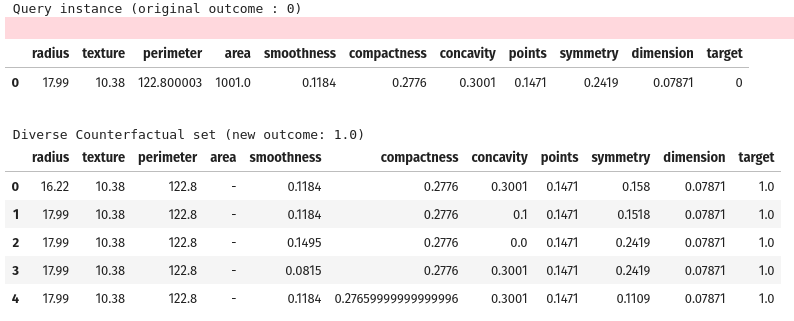 

The figure above shows the counterfactual instances for a particular query instance. 
For each CF example instance very few feature values have only been changed, it is mainly because DiCE considers minimal changes required to produce a counterfactual. It helps the user to find CF-examples that are similar to the original instance and make it easier to adjust the data to produce the desired output.

/tmp/ipykernel_100181/909730370.py:10: RuntimeWarning: divide by zero encountered in log
  lg_cfs = np.log(cfs)


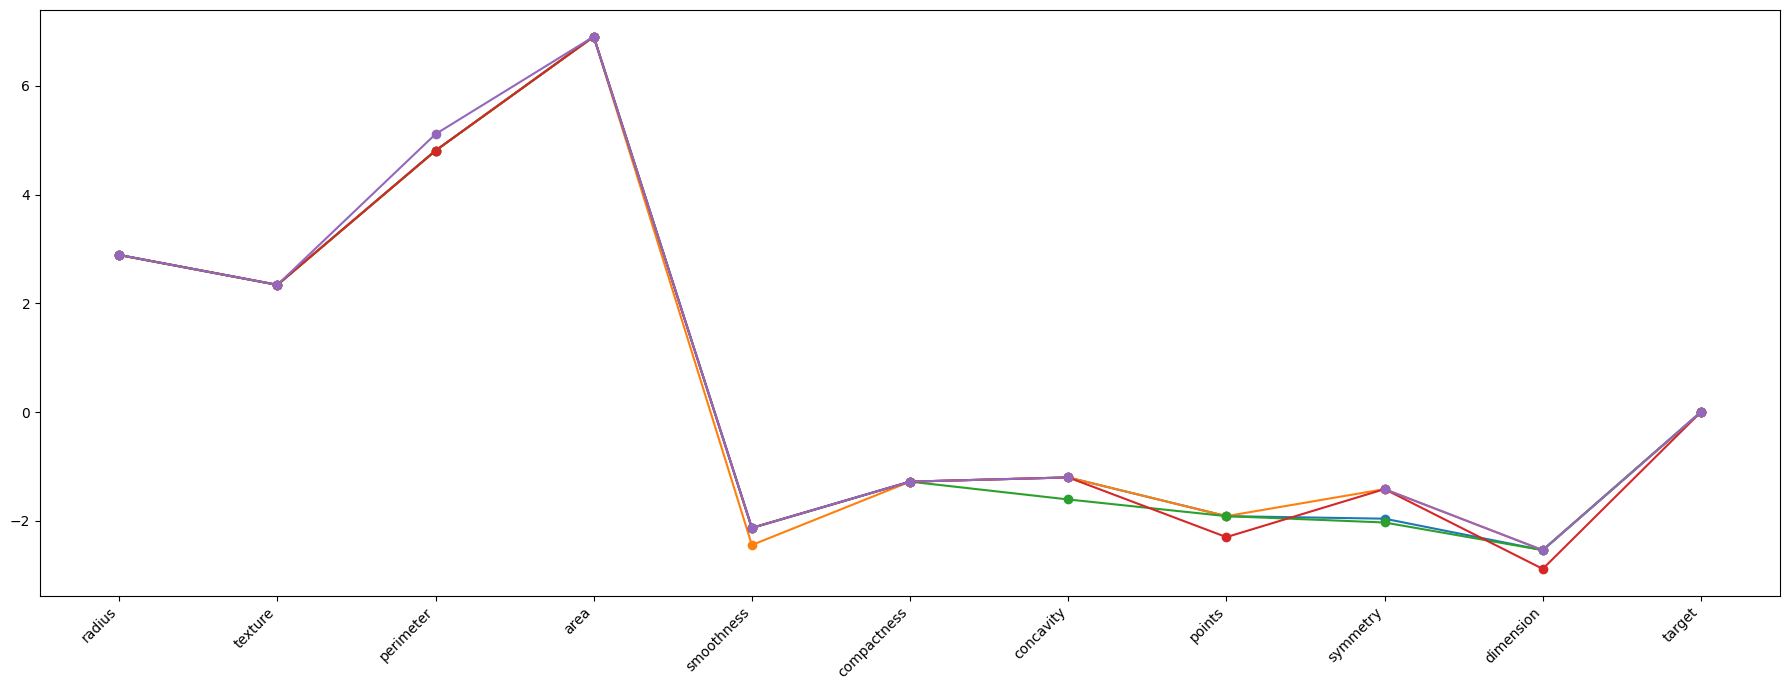

In [7]:
import matplotlib.pyplot as plt
import numpy as np
df_exp1 = exp1.cf_examples_list[0].final_cfs_df

cfs = []
for i, row in df_exp1.iterrows():
    row = row.tolist()
    cfs.append(row)
    
lg_cfs = np.log(cfs)
x = df_exp1.columns.tolist()
fig, ax = plt.subplots(figsize=(18,7))

for i in range(len(lg_cfs)):
    label =  f'CF_instance {i+1}' 
    ax.plot(x, lg_cfs[i], marker='o', label=label)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This figure depicts the CFs generated for a single query instance.  

/tmp/ipykernel_100181/2081116858.py:10: RuntimeWarning: divide by zero encountered in log
  cfs.append(np.log(row)+1 )


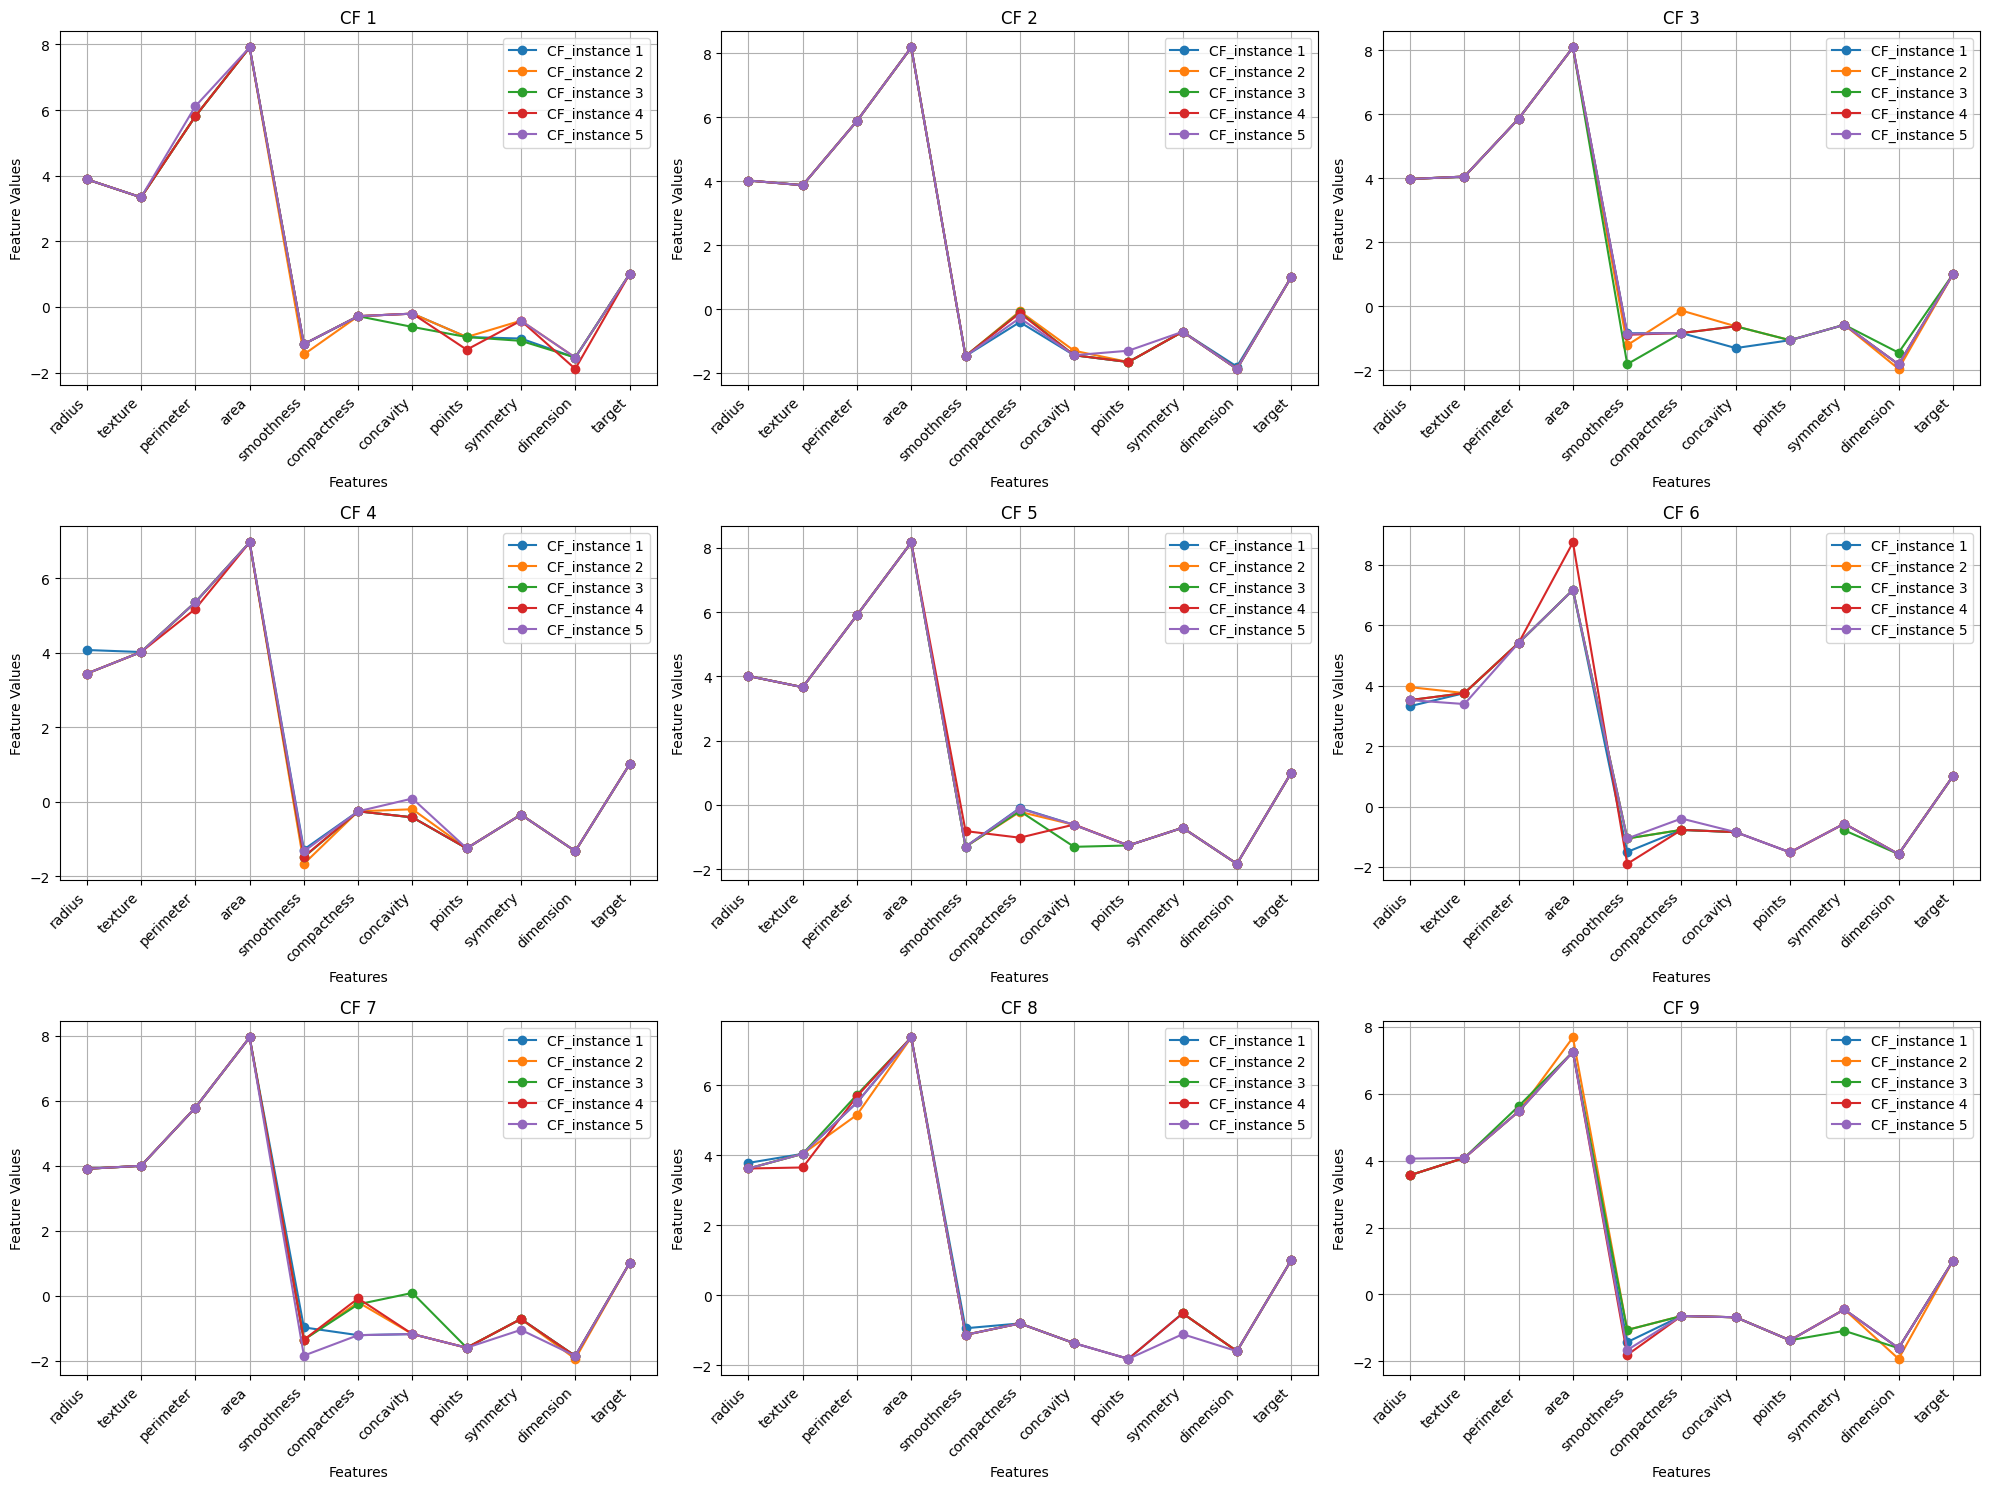

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15))

axs = axs.flatten()

for i, ax in enumerate(axs):
    df_exp1 = exp1.cf_examples_list[i].final_cfs_df
    cfs = []
    for j, row in df_exp1.iterrows():
        row = row.tolist()
        cfs.append(np.log(row)+1 )
        x = df_exp1.columns.tolist()
        label =  f'CF_instance {j+1}' 
        ax.plot(x, cfs[j], marker='o', label=label) 
        ax.set_title(f'CF {i+1}')
        ax.set_xlabel('Features')
        ax.set_ylabel('Feature Values')
        ax.set_xticks(x)
        ax.set_xticklabels(x, rotation=45, ha='right')
        ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

The plots show the features and values of 9 different counterfactual instances. The values are log transformed to scale better.
A preference for certain features can be observed from the plots. Smoothness is found to be one of the features that is more varied compared to other features  such as area in generating counterfactuals. 

Local feature importance scores. DiCE provides local feature importance by evaluating how individual feature values change within counterfactual explanations for a particular data point.

In [9]:
lfi = exp_dice.local_feature_importance(query[:1], total_CFs=10)
print(lfi.local_importance)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]

[{'symmetry': 0.6, 'dimension': 0.3, 'smoothness': 0.2, 'concavity': 0.2, 'texture': 0.1, 'compactness': 0.1, 'points': 0.1, 'radius': 0.0, 'perimeter': 0.0, 'area': 0.0}]


Global feature importance scores

In [10]:
gfi = exp_dice.global_feature_importance(query[:10], total_CFs=10)
print(gfi.summary_importance)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


{'smoothness': 0.44, 'compactness': 0.29, 'symmetry': 0.25, 'dimension': 0.14, 'perimeter': 0.13, 'concavity': 0.12, 'points': 0.09, 'area': 0.08, 'texture': 0.07, 'radius': 0.04}


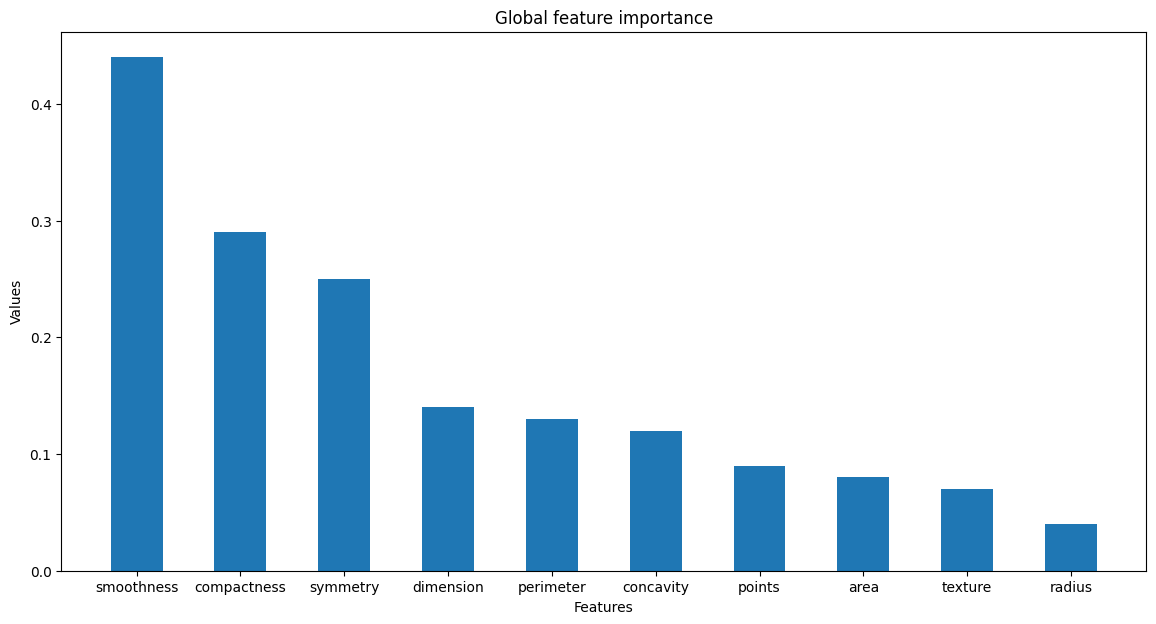

In [11]:
import matplotlib.pyplot as plt
x=gfi.summary_importance.keys()
y=gfi.summary_importance.values()
plt.figure(figsize=(14,7))
plt.bar(x,y, width=0.5)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Global feature importance')
plt.show()

DiCE calculates global feature importance based on the counterfactual explanations it generates. By analyzing these explanations collectively, it can identify which features tend to have the most significant impact on the model's predictions across the entire dataset. The result shows that smoothness is identified to be the feature that has contributed more towards the model's overall prediction outcomes.

Generating CFs by only changing the two most globally important feature values.

In [12]:
exp2 = exp_dice.generate_counterfactuals(query[0:5], total_CFs=5, desired_class="opposite", features_to_vary=['smoothness', 'compactness'])
#exp2.visualize_as_dataframe(show_only_changes=True)
exp2_as_df = exp2.visualize_as_dataframe(show_only_changes=True)
print(exp2_as_df)
#type(exp2_as_df)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]

Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,17.99,10.38,122.800003,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,17.99,10.38,122.8,-,0.0598,0.2776,0.3001,0.1471,0.2419,0.07871,1.0
1,17.99,10.38,122.8,-,0.0562,0.2776,0.3001,0.1471,0.2419,0.07871,1.0
2,17.99,10.38,122.8,-,0.0855,0.2776,0.3001,0.1471,0.2419,0.07871,1.0
3,17.99,10.38,122.8,-,0.0848,0.3168,0.3001,0.1471,0.2419,0.07871,1.0
4,17.99,10.38,122.8,-,0.0671,0.2776,0.3001,0.1471,0.2419,0.07871,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.57,17.77,132.899994,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.57,17.77,132.9,-,0.1327,0.3032,0.0869,0.07017,0.1812,0.05667,1.0
1,20.57,17.77,132.9,-,0.141,0.1111,0.0869,0.07017,0.1812,0.05667,1.0
2,20.57,17.77,132.9,-,0.1323,0.2969,0.0869,0.07017,0.1812,0.05667,1.0
3,20.57,17.77,132.9,-,0.1323,0.181,0.0869,0.07017,0.1812,0.05667,1.0
4,20.57,17.77,132.9,-,0.1321,0.07864,0.0869,0.07017,0.1812,0.05667,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,19.690001,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,19.69,-,-,-,0.1569,0.3325,0.1974,0.1279,0.2069,0.05999,1.0
1,19.69,-,-,-,0.1479,0.331,0.1974,0.1279,0.2069,0.05999,1.0
2,19.69,-,-,-,0.0571,0.2716,0.1974,0.1279,0.2069,0.05999,1.0
3,19.69,-,-,-,0.1561,0.2752,0.1974,0.1279,0.2069,0.05999,1.0
4,19.69,-,-,-,0.1513,0.3312,0.1974,0.1279,0.2069,0.05999,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,11.42,20.379999,77.580002,386.100006,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,11.42,20.38,77.58,386.1,0.0873,0.2839,0.2414,0.1052,0.2597,0.09744,1.0
1,11.42,20.38,77.58,386.1,0.1051,0.2839,0.2414,0.1052,0.2597,0.09744,1.0
2,11.42,20.38,77.58,386.1,0.0971,0.2169,0.2414,0.1052,0.2597,0.09744,1.0
3,11.42,20.38,77.58,386.1,0.1226,0.2839,0.2414,0.1052,0.2597,0.09744,1.0
4,11.42,20.38,77.58,386.1,0.0921,0.2839,0.2414,0.1052,0.2597,0.09744,1.0


Query instance (original outcome : 0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.290001,14.34,135.100006,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,20.29,14.34,135.1,-,0.1466,0.2082,0.198,0.1043,0.1809,0.05883,1.0
1,20.29,14.34,135.1,-,0.1003,0.326,0.198,0.1043,0.1809,0.05883,1.0
2,20.29,14.34,135.1,-,0.0535,0.1569,0.198,0.1043,0.1809,0.05883,1.0
3,20.29,14.34,135.1,-,0.1572,0.2925,0.198,0.1043,0.1809,0.05883,1.0
4,20.29,14.34,135.1,-,0.1003,0.3269,0.198,0.1043,0.1809,0.05883,1.0


None


The above set of counterfactuals are generated by only varying 'smoothness' and 'compactness' which are the features with highest global importance, all other variables are set static. 

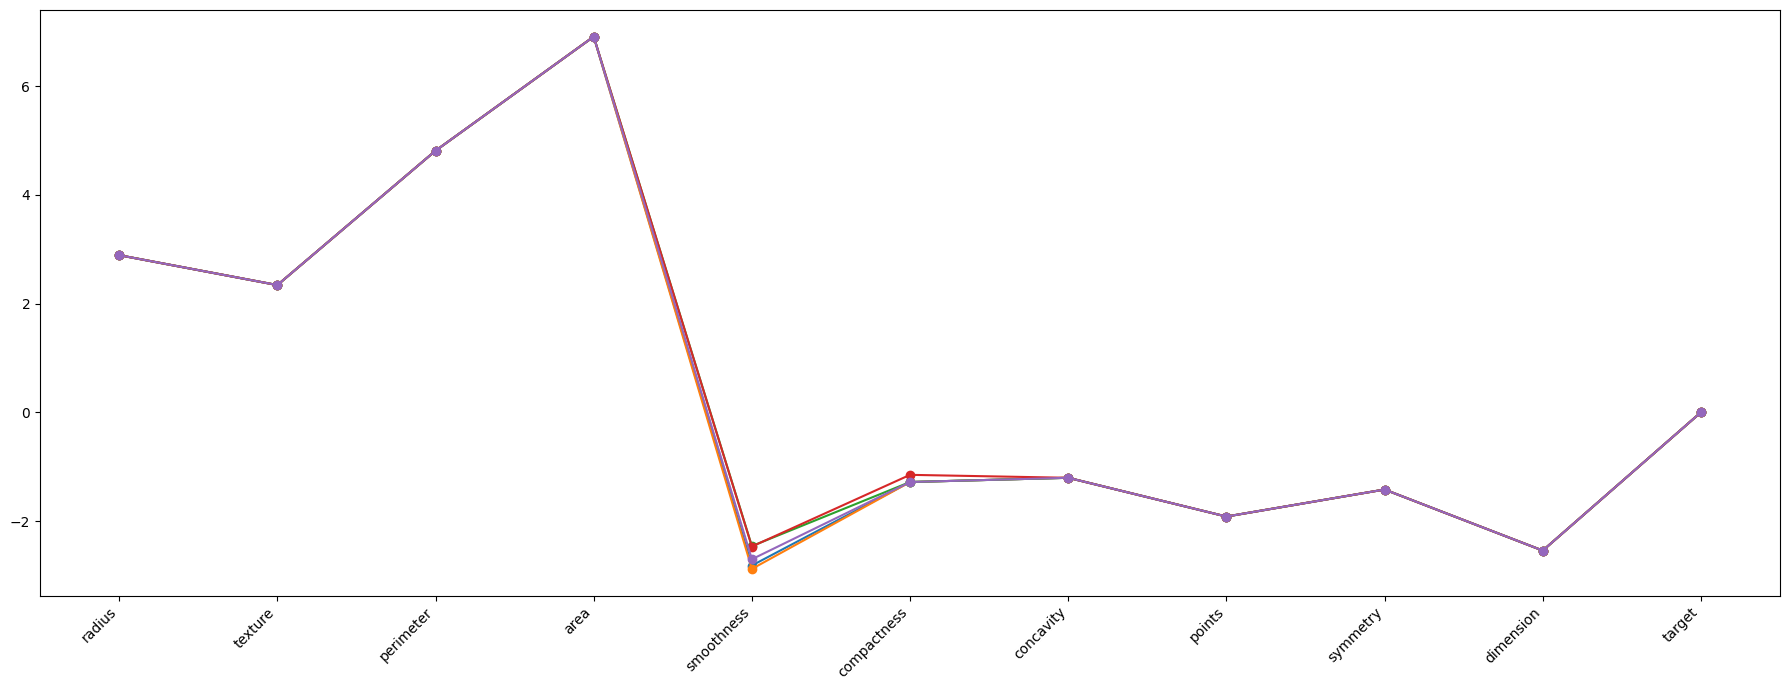

In [13]:
import matplotlib.pyplot as plt
import numpy as np
df_exp2 = exp2.cf_examples_list[0].final_cfs_df
cfs2 = []
for i, row in df_exp2.iterrows():
    row = row.tolist()
    cfs2.append(row)
lg_cfs2 = np.log(cfs2)
x = df_exp2.columns.tolist()
x

fig, ax = plt.subplots(figsize=(18,7))

for i in lg_cfs2:
    ax.plot(x, i,marker='o')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The figure above shows CFs that are formed by only varying 'smoothness' and 'compactness' (two most globally important features).

Changing feature weights: Median Absolute Deviation (MAD)

In [14]:
mads = d.get_mads(normalized=True)
f_weights={}
f_weights={feature:round(1/mads[feature], 2) for feature in mads}
f_weights = sorted(f_weights.items(), key=lambda item: item[1])
print(f_weights)

[('compactness', 9.99), ('points', 9.99), ('texture', 10.52), ('concavity', 10.55), ('radius', 11.12), ('dimension', 11.25), ('perimeter', 11.39), ('symmetry', 11.58), ('smoothness', 11.66), ('area', 15.38)]


f_weights represent the feature weights (MAD scores) of the feature variables. 'area' has the highest weight, it basically means that the values of area are less diverse than other features.

## Insights
This work demostrated the capabilities of DiCE to provide explanations for the predictions of an ML model. Results generated from DiCE helps to visualize the values each feature carried for a particular prediction, this is very effective when it comes to understanding what made the model to predict a particular outcome. When it come to user, DiCE provides multiple alternative predictions with different feature values that generates the desired result. This can help the user to understand the conditions that are needed to be satisfied to get the desired outcome. 